In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
from rootpy.tree import Tree, TreeChain
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun_displaced():
  infiles = []
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1000_CTau-1/ParticleGuns/CRAB3/181024_130734/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1000_CTau-10/ParticleGuns/CRAB3/181024_130843/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1000_CTau-100/ParticleGuns/CRAB3/181024_130954/0000/ntuple_DisplacedSUSY_1.root')  
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1500_CTau-1/ParticleGuns/CRAB3/181024_131221/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1500_CTau-100/ParticleGuns/CRAB3/181024_131447/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1500_CTau-1000/ParticleGuns/CRAB3/181024_131556/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-200_CTau-1/ParticleGuns/CRAB3/181024_131716/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-200_CTau-10/ParticleGuns/CRAB3/181024_131826/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-500_CTau-1/ParticleGuns/CRAB3/181024_132154/0000/ntuple_DisplacedSUSY_1.root')
  infiles.append('root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-500_CTau-100/ParticleGuns/CRAB3/181024_132416/0000/ntuple_DisplacedSUSY_1.root')
  
  tree = TreeChain('ntupler/tree', infiles)
  print('[INFO] Opening file: %s' % ' '.join(infiles))

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

### DisplacedSUSY

The process is:

\begin{align}
H \to \chi_{2}\chi_{2} \to \left(\chi_{1} Z_{d}\right) \left(\chi_{1} Z_{d}\right) \to \left(\mu^{+}\mu^{-}\right) \left(\mu^{+}\mu^{-}\right) + {{\vec E}_\mathrm{T}\mkern{-0.75em}/} \\
\end{align}

The dark photon $Z_{d}$ has mass $m_{Z_{d}}$. The decay of $Z_{d} \to \mu^{+}\mu^{-}$ has lifetime $c\tau$. These two parameters are free parameters.

In [4]:
"""
Some people, when confronted with a problem, think "I know, I'll use regular expressions." Now they have two problems.
"""

import re

def parse_filepath(filepath):
  try:
    p = '.*ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-(\d+)_CTau-(\d+)/.*'
    m = re.match(p, filepath)
    mGammaD, ctau = map(int, m.groups())
    return mGammaD, ctau
  except:
    raise Exception('Failed to parse filepath to get mGammaD, ctau.')

filepath = 'root://cmsxrootd-site.fnal.gov//store/user/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_DisplacedSUSY_SmuonToMuNeutralino_M-1000_CTau-1/ParticleGuns/CRAB3/181019_230453/0000/ntuple_DisplacedSUSY_1.root'
parse_filepath(filepath)

(1000, 1)

In [5]:
maxEvents = 4000000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

from six.moves import range, zip, map, filter

mGammaD_list = [200, 500, 1000, 1500]
ctau_list = [1, 10, 100, 1000]

In [6]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun_displaced()
  
  out_susy, out_parts = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose:
      if (ievt % 10000) == 0:  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    #if not len(evt.hits) >= 4:
    #  continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    # Get DisplacedSUSY model parameters
    filepath = tree._files[tree.curr_file_idx-1]
    mGammaD, ctau = parse_filepath(filepath)
    ievt_susy = (mGammaD, ctau)
    
    # Get particles
    ievt_parts = []
    for part in evt.particles:
      if part.status == 1 and part.pt > 2:
        assert(np.abs(part.pdgid) == 13)
        part.invpt = np.true_divide(part.q, part.pt)
        part.Lxy = np.sqrt(part.vx*part.vx + part.vy*part.vy)  # in cm
        part.Lz = np.abs(part.vz)  # in cm
        ievt_parts.append((part.pdgid, part.invpt, part.eta, part.phi, part.Lxy, part.Lz))
    
    # Verbose
    if verbose > 1:
      print("ievt {0}".format(ievt))
      for part in evt.particles:
        if part.status == 1 and part.pt > 2:
          print(".. {0} {1} {2} {3} {4} {5}".format(part.pdgid, part.genp, part.q, part.pt, part.eta, part.phi))
    
    # Output
    if len(ievt_parts) < 4:
      # Pad with -99
      n = 4 - len(ievt_parts)
      for i in xrange(n):
        ievt_parts.append((-99, -99, -99, -99, -99, -99))

    if len(ievt_parts) == 4:
      out_susy.append(ievt_susy)
      out_parts.append(ievt_parts)
    continue  # end loop over events

  if verbose:
    print "DONE"
  return np.asarray(out_susy), np.asarray(out_parts)

In [7]:
loaded = np.load('displaced_out.1.npz')
out_susy = loaded['out_susy']
out_parts = loaded['out_parts']

In [8]:
print out_susy.shape, out_parts.shape, out_susy.dtype, out_parts.dtype

(912926, 2) (912926, 4, 6) int64 float64


### Plots


<p>
<font color="#1f77b4" size=12>&FilledSmallSquare;</font>
<font color="#ff7f0e" size=12>&FilledSmallSquare;</font>
<font color="#2ca02c" size=12>&FilledSmallSquare;</font>
<font color="#d62728" size=12>&FilledSmallSquare;</font>
<font color="#9467bd" size=12>&FilledSmallSquare;</font>
<font color="#8c564b" size=12>&FilledSmallSquare;</font>
<font color="#e377c2" size=12>&FilledSmallSquare;</font>
<font color="#7f7f7f" size=12>&FilledSmallSquare;</font>
<font color="#bcbd22" size=12>&FilledSmallSquare;</font>
<font color="#17becf" size=12>&FilledSmallSquare;</font>
</p>

In [9]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

200 1 (99999, 4, 6) (99999, 4) (185213, 6)
200 10 (99998, 4, 6) (99998, 4) (185080, 6)
500 1 (94989, 4, 6) (94989, 4) (185958, 6)
500 100 (95994, 4, 6) (95994, 4) (188085, 6)
1000 1 (95989, 4, 6) (95989, 4) (190899, 6)
1000 10 (99987, 4, 6) (99987, 4) (198850, 6)
1000 100 (29997, 4, 6) (29997, 4) (59646, 6)
1500 1 (99990, 4, 6) (99990, 4) (199491, 6)
1500 100 (99991, 4, 6) (99991, 4) (199496, 6)
1500 1000 (95992, 4, 6) (95992, 4) (191612, 6)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


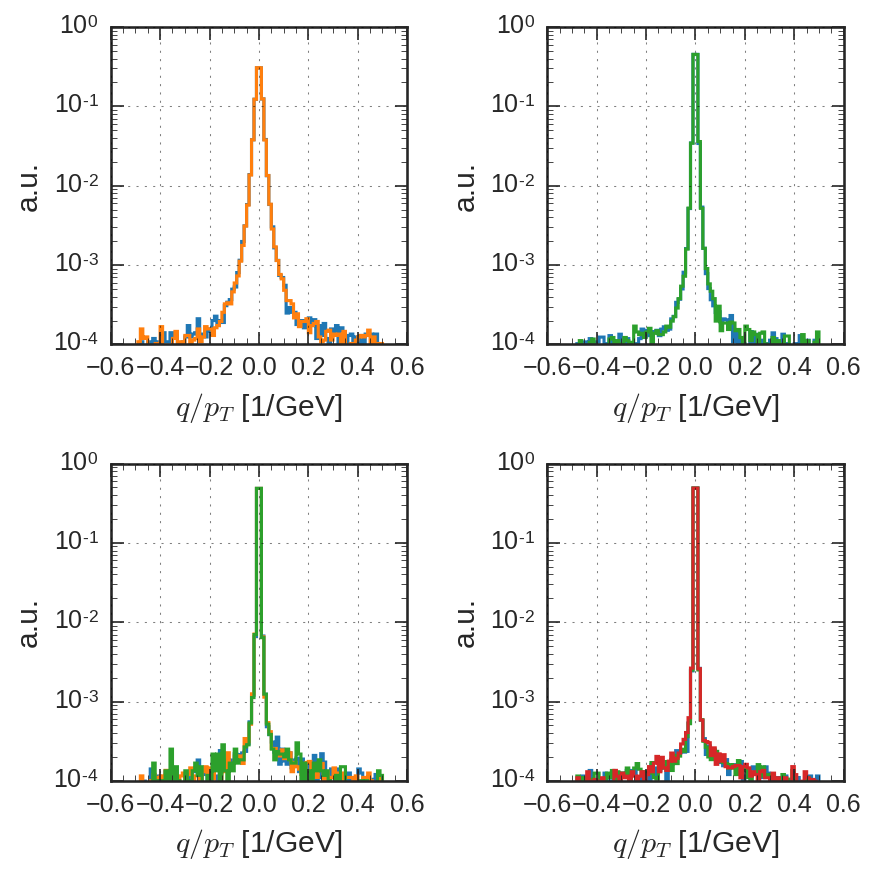

In [10]:
# Plot pT

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), tight_layout=True)

linbins = np.linspace(-0.5, 0.5, num=101)
linbinwidths = np.diff(linbins)
linbincenters = 0.5 * (linbins[1:] + linbins[:-1])

for i in xrange(len(mGammaD_list)):
  for j in xrange(len(ctau_list)):
    mGammaD = mGammaD_list[i]
    ctau = ctau_list[j]
    ax = axs[i/2, i%2]
    
    ind = (out_susy[:,0] == mGammaD) & (out_susy[:,1] == ctau)
    
    if np.count_nonzero(ind):
      y = out_parts[ind]  # pdgid, invpt, eta, phi, Lxy, Lz
      y0 = y[:,:,0].astype(np.int32)
      y1 = y[y0 != -99]   # valid pdgid
      print mGammaD, ctau, y.shape, y0.shape, y1.shape
      
      yy = y1[:,1]  # invpt
      #print np.mean(np.abs(1.0/yy))
      
      #ax.hist(yy, bins=linbins, normed=True, histtype='step', linewidth=1.5, color=category10_palette[j])
      hist, _ = np.histogram(yy, bins=linbins, density=True)
      if hist.sum() > 0:
        ax.hist(linbincenters, weights=hist/hist.sum(), bins=linbins, histtype='step', linewidth=1.5, color=category10_palette[j])

      ax.set_xlabel(r'$q/p_{T}$ [1/GeV]')
      ax.set_ylabel(r'a.u.')
      ax.set_yscale('log')
      ax.set_ylim(1e-4, 1e0)

plt.show()

200 1 (99999, 4, 6) (99999, 4) (99999, 4)
200 10 (99998, 4, 6) (99998, 4) (99998, 4)
500 1 (94989, 4, 6) (94989, 4) (94989, 4)
500 100 (95994, 4, 6) (95994, 4) (95994, 4)
1000 1 (95989, 4, 6) (95989, 4) (95989, 4)
1000 10 (99987, 4, 6) (99987, 4) (99987, 4)
1000 100 (29997, 4, 6) (29997, 4) (29997, 4)
1500 1 (99990, 4, 6) (99990, 4) (99990, 4)
1500 100 (99991, 4, 6) (99991, 4) (99991, 4)
1500 1000 (95992, 4, 6) (95992, 4) (95992, 4)


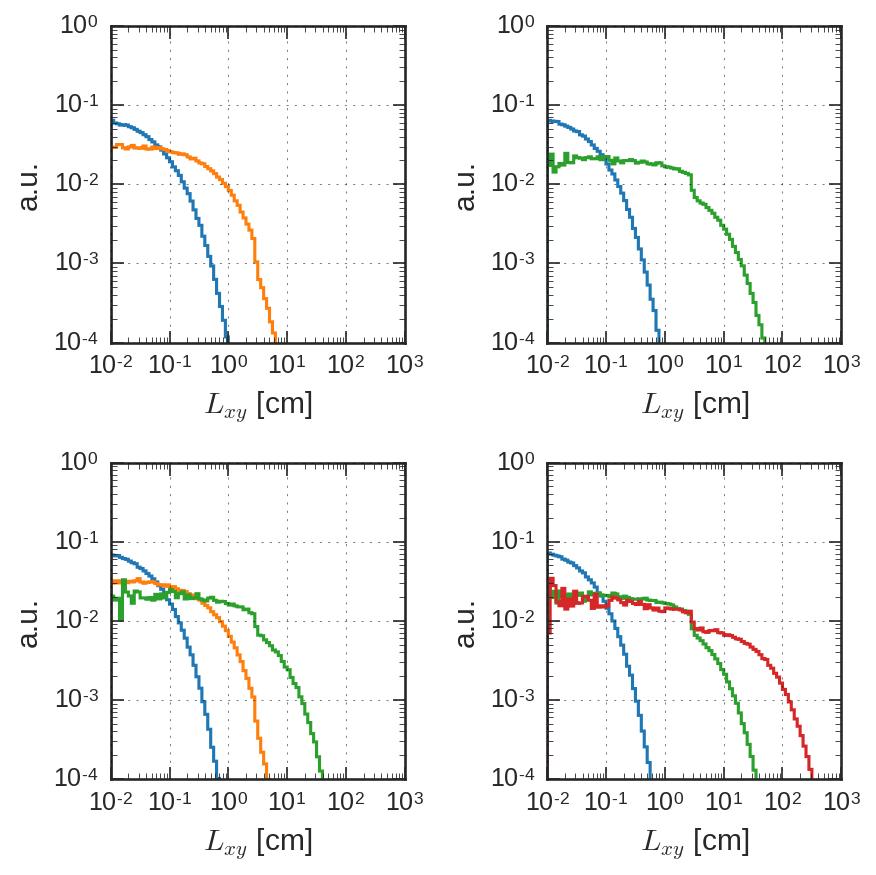

In [11]:
# Plot Lxy

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), tight_layout=True)

logbins = np.logspace(-2, 3, num=101)
logbinwidths = np.diff(logbins)
logbincenters = 0.5 * (logbins[1:] + logbins[:-1])

for i in xrange(len(mGammaD_list)):
  for j in xrange(len(ctau_list)):
    mGammaD = mGammaD_list[i]
    ctau = ctau_list[j]
    ax = axs[i/2, i%2]
    
    ind = (out_susy[:,0] == mGammaD) & (out_susy[:,1] == ctau)
    
    if np.count_nonzero(ind):
      y = out_parts[ind]  # pdgid, invpt, eta, phi, Lxy, Lz
      y0 = y[:,:,0].astype(np.int32)
      y1 = np.abs(1.0/y[:,:,1])
      y2 = y[(y0 != -99) & (y1 > 10)]  # valid pdgid, pt > 10
      print mGammaD, ctau, y.shape, y0.shape, y1.shape
      
      yy = y2[:,4]  # Lxy
      #print np.mean(np.abs(yy))
      
      #ax.hist(yy, bins=logbins, normed=True, histtype='step', linewidth=1.5, color=category10_palette[j])
      hist, _ = np.histogram(yy, bins=logbins, density=True)
      if hist.sum() > 0:
        ax.hist(logbincenters, weights=hist/hist.sum(), bins=logbins, histtype='step', linewidth=1.5, color=category10_palette[j])
      
      ax.set_xlabel(r'$L_{xy}$ [cm]')
      ax.set_ylabel(r'a.u.')
      ax.set_xscale('log')
      ax.set_yscale('log')
      ax.set_ylim(1e-4, 1e0)

plt.show()

200 1 (99999, 4, 6) (99999, 4) (99999, 4)
200 10 (99998, 4, 6) (99998, 4) (99998, 4)
500 1 (94989, 4, 6) (94989, 4) (94989, 4)
500 100 (95994, 4, 6) (95994, 4) (95994, 4)
1000 1 (95989, 4, 6) (95989, 4) (95989, 4)
1000 10 (99987, 4, 6) (99987, 4) (99987, 4)
1000 100 (29997, 4, 6) (29997, 4) (29997, 4)
1500 1 (99990, 4, 6) (99990, 4) (99990, 4)
1500 100 (99991, 4, 6) (99991, 4) (99991, 4)
1500 1000 (95992, 4, 6) (95992, 4) (95992, 4)


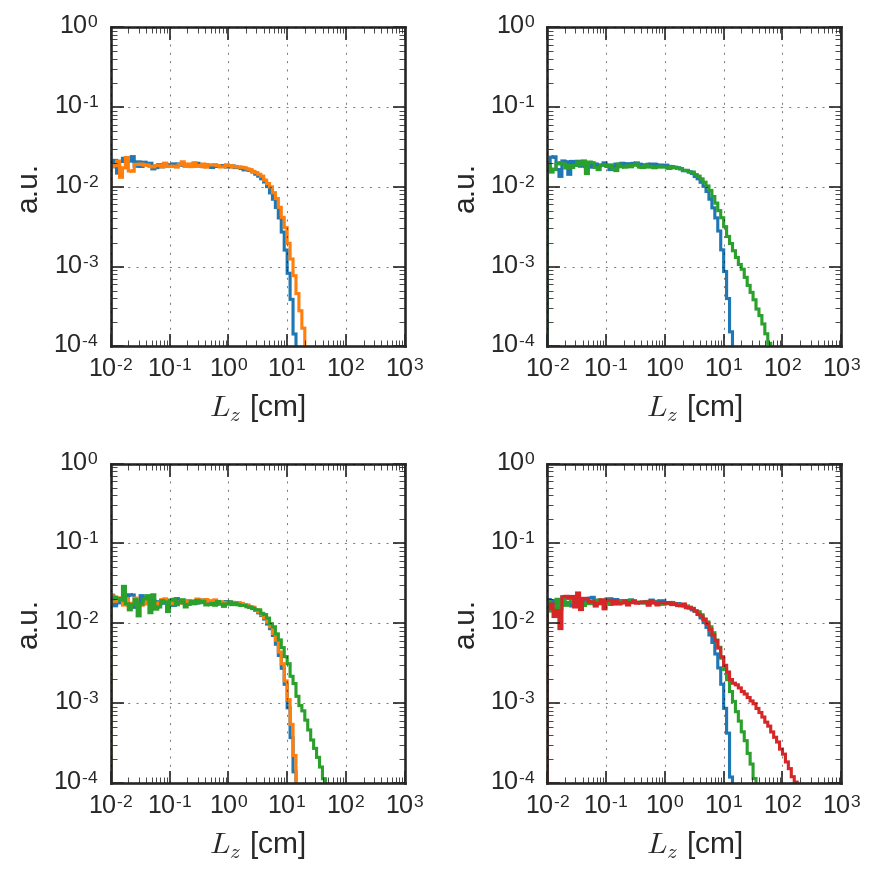

In [12]:
# Plot Lz

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), tight_layout=True)

logbins = np.logspace(-2, 3, num=101)
logbinwidths = np.diff(logbins)
logbincenters = 0.5 * (logbins[1:] + logbins[:-1])

for i in xrange(len(mGammaD_list)):
  for j in xrange(len(ctau_list)):
    mGammaD = mGammaD_list[i]
    ctau = ctau_list[j]
    ax = axs[i/2, i%2]
    
    ind = (out_susy[:,0] == mGammaD) & (out_susy[:,1] == ctau)
    
    if np.count_nonzero(ind):
      y = out_parts[ind]  # pdgid, invpt, eta, phi, Lxy, Lz
      y0 = y[:,:,0].astype(np.int32)
      y1 = np.abs(1.0/y[:,:,1])
      y2 = y[(y0 != -99) & (y1 > 10)]  # valid pdgid, pt > 10
      print mGammaD, ctau, y.shape, y0.shape, y1.shape
      
      yy = y2[:,5]  # Lz
      #print np.mean(np.abs(yy))
      
      #ax.hist(yy, bins=logbins, normed=True, histtype='step', linewidth=1.5, color=category10_palette[j])
      hist, _ = np.histogram(yy, bins=logbins, density=True)
      if hist.sum() > 0:
        ax.hist(logbincenters, weights=hist/hist.sum(), bins=logbins, histtype='step', linewidth=1.5, color=category10_palette[j])
      
      ax.set_xlabel(r'$L_{z}$ [cm]')
      ax.set_ylabel(r'a.u.')
      ax.set_xscale('log')
      ax.set_yscale('log')
      ax.set_ylim(1e-4, 1e0)

plt.show()